In [2]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [44]:
# MLP
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 0.5) #Kaiming init * 0.1
b1 = torch.randn(n_hidden,                        generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [29]:
# Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    
    # back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())     

      0/ 100000: 1.8910
  10000/ 100000: 2.0565
  20000/ 100000: 2.2727
  30000/ 100000: 2.1771
  40000/ 100000: 2.1600
  50000/ 100000: 2.7604
  60000/ 100000: 2.3876
  70000/ 100000: 2.2545
  80000/ 100000: 2.2027
  90000/ 100000: 1.8810
 100000/ 100000: 2.2209


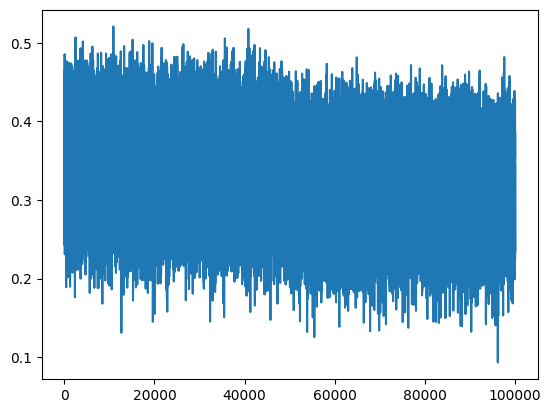

In [30]:
plt.plot(lossi)

In [32]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 +b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0929157733917236
val 2.1449546813964844


In [33]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

montaymyah.
seel.
mahayla.
ren.
ruchadraegan.
eled.
elin.
shi.
jen.
eden.
estanara.
mykima.
kalin.
shub.
ridhimies.
kinde.
jennoxrah.
casunne.
cda.
kylene.


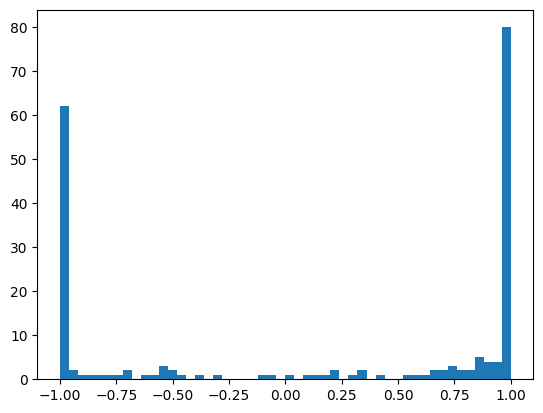

In [35]:
plt.hist(h.view(-1).tolist(), 50);

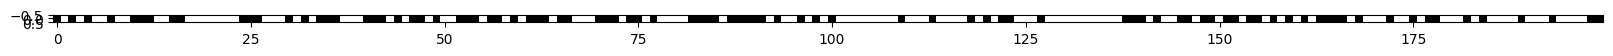

# Full code v1: compilation
I have now compiled the original full code, we will make edits on this version

In [48]:
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) 
b1 = torch.randn(n_hidden,                        generator = g) 
W2 = torch.randn((n_hidden, vocab_size),          generator = g) 
b2 = torch.randn(vocab_size,                      generator = g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
    # Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    
    # back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
    
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 +b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')   

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
11897
      0/ 100000: 27.8817
  10000/ 100000: 2.8483
  20000/ 100000: 2.5429
  30000/ 100000: 2.7459
  40000/ 100000: 2.1223
  50000/ 100000: 2.5109
  60000/ 100000: 2.4909
  70000/ 100000: 1.9937
  80000/ 100000: 2.2218
  90000/ 100000: 2.0624
 100000/ 100000: 1.9058
train 2.176344633102417
val 2.202533483505249
mora.
mayah.
seel.
nihahlie.
emmadceja.


# Full code v2: reduce the biases 

For the v1, we recognise the biases are random numbers, plugging that into a tanh activation function could lead to multiple 1 or -1 values as tanh(10) = 1.  Values of 1 and -1 would pass the node and will not auto correct. It is best to have the weights close to 0 but NOT 0 to allow for entropy.

Bias terms in general can be very close to 0. For the case of logits bias (last bias term, we can initialise it at 0)

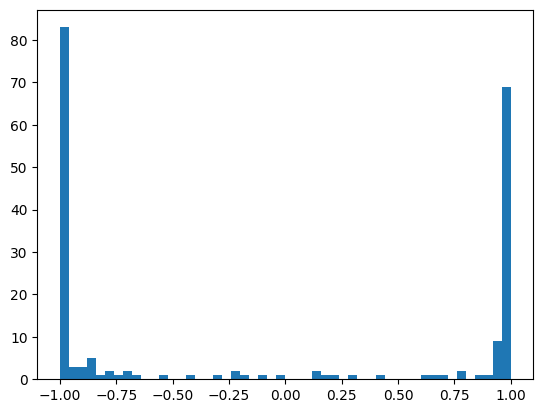

In [49]:
plt.hist(h.view(-1).tolist(), 50);

In [50]:
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP
n_embd = 10
n_hidden = 200

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * 0.1
b1 = torch.randn(n_hidden,                        generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
# Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    
    # back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
    
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 +b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')   

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
11897
      0/ 100000: 3.3069
  10000/ 100000: 2.1900
  20000/ 100000: 2.2707
  30000/ 100000: 2.4296
  40000/ 100000: 1.9041
  50000/ 100000: 2.3865
  60000/ 100000: 2.3421
  70000/ 100000: 1.9668
  80000/ 100000: 2.1754
  90000/ 100000: 2.0368
 100000/ 100000: 1.8858
train 2.0854735374450684
val 2.1262447834014893
montaymya.
ziee.
medhayla.
remmastendraegan.
ched.


# Full code v3: Kaiming init

Having some intuition of setting the initial biases is great, but we dont want magic numbers. A good way to prevent the magic numbers for the initialisation of the tanh function is to set the formalisation such that the standard deviation of the h sample is 1. This is called the Kaiming Initialisation.

Setting the initialisation scale factor of normalisation for the h value biases of 0.1 gives us:

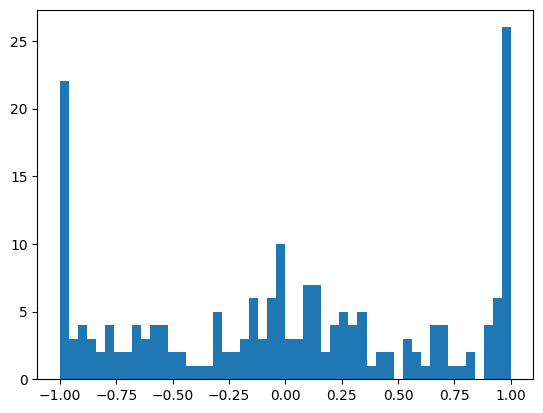

In [51]:
plt.hist(h.view(-1).tolist(), 50);

This is a lot better, much less 1's and -1's

In [52]:
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP
n_embd = 10
n_hidden = 200

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 0.5) # Kaiming init 
b1 = torch.randn(n_hidden,                        generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
    # Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    
    # back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
    
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 +b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')   

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
11897
      0/ 100000: 3.3179
  10000/ 100000: 2.1910
  20000/ 100000: 2.3270
  30000/ 100000: 2.5396
  40000/ 100000: 1.9468
  50000/ 100000: 2.3331
  60000/ 100000: 2.3914
  70000/ 100000: 2.0292
  80000/ 100000: 2.1964
  90000/ 100000: 2.0683
 100000/ 100000: 1.8759
train 2.0623960494995117
val 2.114367961883545
mon.
ammyah.
see.
med.
rylle.


The validation loss has once again decreased. Get to the same place, but with less magic numbers, and scalable

# Full code v4: Batch normalisation

We want unit batch to be initialised as Gaussians so mean of 0, standard deviation of 1. But we want to allow the batches to move around, so we add a bias so bngain and bnbias

In [57]:
hpreact.shape

torch.Size([32, 200])

In [61]:
hpreact.mean(0, keepdim = True).shape

torch.Size([1, 200])

In [62]:
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [1]:
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 0.5) # Kaiming init 
b1 = torch.randn(n_hidden,                        generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
    # Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    
    # back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
   
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 +b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')   

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


NameError: name 'torch' is not defined

Batch normalisation has increased significantly, this is very useful for larger scale deep learning frameworks. We can also see we have broken our sampling names as they are illegible.

In [85]:
# Code is broken

words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 0.5) # Kaiming init 
b1 = torch.randn(n_hidden,                        generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
# Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 +b1#no need for bias, already considered in bnbias + b1 
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running.mul_(0.999).add_(0.001 * bnmeani)
        bnstd_running.mul_(0.999).add_(0.001 * bnstdi)
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    
    # back pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
   
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 +b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')   

#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------
#--------- EDIT HERE ---------------

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
12297


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [107]:
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build in dataset
block_size = 3

def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP
n_embd = 10 # character embedding vectors
n_hidden = 200 # the number of neurons for MLP

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator = g, requires_grad=True)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g, requires_grad=True) * (5/3) / ((n_embd * block_size) ** 0.5) # Kaiming init 
b1 = torch.randn(n_hidden,                        generator = g, requires_grad=True) * 0.01 # no need for this, since batch normalisation
W2 = torch.randn((n_hidden, vocab_size),          generator = g, requires_grad=True) * 0.01
b2 = torch.randn(vocab_size,                      generator = g, requires_grad=True) * 0

# Batch normalisation parameters
bngain = torch.ones((1, n_hidden), requires_grad=True)
bnbias = torch.zeros((1, n_hidden), requires_grad=True)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1,  W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
12297


In [108]:
# Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # linear layer
    hpreact = embcat @ W1 #+b1#no need for bias, already considered in bnbias + b1 
    
    # batch normalisation layer
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = (hpreact.var(0, unbiased=False, keepdim=True) + 1e-5).sqrt()
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running.mul_(0.999).add_(0.001 * bnmeani.detach())
        bnstd_running.mul_(0.999).add_(0.001 * bnstdi.detach())
        
    # none-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,  Yb)
    print("Step:", i)
    print("Xb.shape:", Xb.shape)
    print("Yb.shape:", Yb.shape)
    print("emb.shape:", emb.shape)
    print("embcat.shape:", embcat.shape)
    print("hpreact.shape before batchnorm:", hpreact.shape)
    print("bnmeani.shape:", bnmeani.shape)
    print("bnstdi.shape:", bnstdi.shape)
    print("hpreact.shape after batchnorm:", hpreact.shape)
    print("h.shape:", h.shape)
    print("logits.shape:", logits.shape)
    print("loss:", loss.item())
    print()

    # back pass
    for p in parameters:
        print(p.shape, p.requires_grad)
        p.grad = None
    print(loss.requires_grad)
    loss.backward()

    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
   

Step: 0
Xb.shape: torch.Size([32, 3])
Yb.shape: torch.Size([32])
emb.shape: torch.Size([32, 3, 10])
embcat.shape: torch.Size([32, 30])
hpreact.shape before batchnorm: torch.Size([32, 200])
bnmeani.shape: torch.Size([1, 200])
bnstdi.shape: torch.Size([1, 200])
hpreact.shape after batchnorm: torch.Size([32, 200])
h.shape: torch.Size([32, 200])
logits.shape: torch.Size([32, 27])
loss: 3.3148627281188965

torch.Size([27, 10]) True
torch.Size([30, 200]) True
torch.Size([200]) True
torch.Size([200, 27]) True
torch.Size([27]) True
torch.Size([1, 200]) True
torch.Size([1, 200]) True
False


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [111]:
import torch
import torch.nn.functional as F
import random

# Load dataset
words = open('names.txt', 'r').read().splitlines()

# Build vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# Dataset
block_size = 3

def build_dataset(words, block=3):
    X, Y = [], []
    for w in words:
        context = [0] * block
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP parameters
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g, requires_grad=True)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, requires_grad=True)
W1.data *= (5/3) / ((n_embd * block_size) ** 0.5)
b1 = (torch.randn(n_hidden, generator=g) * 0.01).requires_grad_()
W2 = (torch.randn((n_hidden, vocab_size), generator=g) * 0.01).requires_grad_()
b2 = (torch.randn(vocab_size, generator=g) * 0).requires_grad_()

# Batchnorm parameters
bngain = torch.ones((1, n_hidden), requires_grad=True)
bnbias = torch.zeros((1, n_hidden), requires_grad=True)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("Total parameters:", sum(p.nelement() for p in parameters))

# Optimisation
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]                           # (batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)    # (batch_size, block_size * n_embd)
    hpreact = embcat @ W1                  # (batch_size, n_hidden)

    # Batchnorm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = (hpreact.var(0, unbiased=False, keepdim=True) + 1e-5).sqrt()
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running.mul_(0.999).add_(0.001 * bnmeani.detach())
        bnstd_running.mul_(0.999).add_(0.001 * bnstdi.detach())

    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < (max_steps // 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Logging
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# Loss after training
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Sampling new names
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
Total parameters: 12297


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn